In [52]:
import os
import scipy.io
import random
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import tqdm

### Readme for dataset:

17 Flower Category Database
----------------------------------------------
This set contains images of flowers belonging to 17 different categories. 
The images were acquired by searching the web and taking pictures. There are
80 images for each category. 

The database was used in:

Nilsback, M-E. and Zisserman, A.  A Visual Vocabulary for Flower Classification.
Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (2006) 
http://www.robots.ox.ac.uk/~vgg/publications/papers/nilsback06.{pdf,ps.gz}.

The datasplits used in this paper are specified in datasplits.mat

There are 3 separate splits. The results in the paper are averaged over the 3 splits.
Each split has a training file (trn1,trn2,trn3), a validation file (val1, val2, val3)
and a testfile (tst1, tst2 or tst3). 

Segmentation Ground Truth
------------------------------------------------
The ground truth is given for a subset of the images from 13 different
categories. 

More details can be found in:

Nilsback, M-E. and Zisserman, A. Delving into the whorl of flower segmentation.
Proceedings of the British Machine Vision Conference (2007)
http:www.robots.ox.ac.uk/~vgg/publications/papers/nilsback06.(pdf,ps.gz).

The ground truth file also contains the file imlist.mat, which indicated
which images in the original database that have been anotated.

Distance matrices
-----------------------------------------------

We provide two set of distance matrices:

1. distancematrices17gcfeat06.mat 
- Distance matrices using the same features and segmentation as detailed in:
    Nilsback, M-E. and Zisserman, A.  A Visual Vocabulary for Flower Classification.
    Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition(2006)
    http://www.robots.ox.ac.uk/~vgg/publications/papers/nilsback06.{pdf,ps.gz}.

2. distancematrices17itfeat08.mat
- Distance matrices using the same features as described in: 
    Nilsback, M-E. and Zisserman, A. Automated flower classification over a large number of classes.
    Proceedings of the Indian Conference on Computer Vision, Graphics and Image Processing (2008)
    http://www.robots.ox.ac.uk/~vgg/publications/papers/nilsback08.{pdf,ps.gz}.
  and the iterative segmenation scheme detailed in 
    Nilsback, M-E. and Zisserman, A. Delving into the whorl of flower segmentation.
    Proceedings of the British Machine Vision Conference (2007)
    http:www.robots.ox.ac.uk/~vgg/publications/papers/nilsback06.(pdf,ps.gz).
  

In [3]:
images_path="data/jpg/files.txt"

with open(images_path) as f:
    file_names= f.read().splitlines()


print(len(os.listdir("data/jpg")))
print(len(file_names))
file_names[:5]


1362
1360


['image_0001.jpg',
 'image_0002.jpg',
 'image_0003.jpg',
 'image_0004.jpg',
 'image_0005.jpg']

In [4]:
sgms_path="data/trimaps/"

sgm_files=[f for f in os.listdir(sgms_path) if "image" in f]

print(len(sgm_files))
sgm_files[:5]

848


['image_0387.png',
 'image_0436.png',
 'image_0350.png',
 'image_0344.png',
 'image_0422.png']

In [5]:
mat = scipy.io.loadmat('data/trimaps/imlist.mat')
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'imlist'])

In [6]:
print(mat["__header__"])
print(mat["__version__"])
print(mat["__globals__"])
print(len(mat["imlist"][0]))

imlist=list(mat["imlist"][0])


b'MATLAB 5.0 MAT-file, Platform: GLNX86, Created on: Sun Apr 29 00:19:15 2007'
1.0
[]
753


In [7]:
def get_image_id(file_name):
    no_extension=file_name.split(".")[0]
    image_id=no_extension.split("_")[1]
    return int(image_id)

get_image_id("image_0001.jpg")

1

Relations of these sets:

In [8]:
file_names_set = set([get_image_id(f) for f in file_names])
imlist_set = set(imlist)
sgm_files_set = set([get_image_id(f) for f in sgm_files])

print(len(imlist_set.difference(file_names_set)))
print(len(sgm_files_set.difference(file_names_set)))
print(len(imlist_set.difference(sgm_files_set)))
print(len(sgm_files_set.difference(imlist_set)))



0
0
0
95


The datasplits used in this paper are specified in datasplits.mat

There are 3 separate splits. The results in the paper are averaged over the 3 splits.
Each split has a training file (trn1,trn2,trn3), a validation file (val1, val2, val3)
and a testfile (tst1, tst2 or tst3). 

In [9]:
datasplits = scipy.io.loadmat('data/datasplits.mat')
datasplits.keys()

dict_keys(['__header__', '__version__', '__globals__', 'trn1', 'trn2', 'trn3', 'tst1', 'tst2', 'tst3', 'val3', 'val2', 'val1'])

In [10]:
keys=['trn1', 'trn2', 'trn3', 'tst1', 'tst2', 'tst3', 'val3', 'val2', 'val1']

for key in keys:
    print(f"{key}: {datasplits[key].shape}")

trn1: (1, 680)
trn2: (1, 680)
trn3: (1, 680)
tst1: (1, 340)
tst2: (1, 340)
tst3: (1, 340)
val3: (1, 340)
val2: (1, 340)
val1: (1, 340)


## Goal:

"Your task is to train a quick proof of concept model verifying the feasibility of detecting flower species in images coming from this dataset"

For this task no validation split is needed, since the test loss shows the generalization of the model. Also, we can merge all these sets in one big train set and another smaller test set.

In [11]:
N=len(sgm_files_set)
print (f" The number of segmentations: {N}")

RATIO=0.8

data=list(sgm_files_set)
random.shuffle(data)

train_data = data[:int(RATIO*N)]
test_data = data[int(RATIO*N):]

print(f"Size of train set {len(train_data)}")
print(f"Size of test set {len(test_data)}")


 The number of segmentations: 848
Size of train set 678
Size of test set 170


Saving the shuffled train and test sets

In [12]:
with open("data/train_set.json","w") as f:
    json.dump(train_data, f)

with open("data/test_set.json","w") as f:
    json.dump(test_data, f)

## Exploring instances

In [13]:
def read_images(image_id, plot=False):
    image_name=f"image_{image_id:04}.jpg"
    img=mpimg.imread(f"data/jpg/{image_name}")

    sgm_name=f"image_{image_id:04}.png"
    sgm=mpimg.imread(f"data/trimaps/{sgm_name}")

    if plot:
        fig, ax = plt.subplots(1,2)
        ax[0].imshow(img)
        ax[1].imshow(sgm)

    return img, sgm
    
    

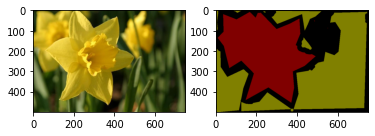

In [42]:
img, sgm= read_images(5, plot=True)

In [43]:
print(img.shape)
print(sgm.shape)


(500, 749, 3)
(500, 749, 4)


In [44]:
print(f"Yellow: {sgm[150,650,:]}")
print(f"Red: {sgm[200,200,:]}")
print(f"Black: {sgm[150,500,:]}")

red_rgb=sgm[200,200,:]
yellow_rgb=sgm[150,650,:]


Yellow: [0.5019608 0.5019608 0.        1.       ]
Red: [0.5019608 0.        0.        1.       ]
Black: [0. 0. 0. 1.]


Segmentation data is four dimensional, but the last one is always 

In [17]:
sgm[200,200,0]

0.5019608

In [18]:
print(min(sgm[...,3].flatten()))
print(max(sgm[...,3].flatten()))

1.0
1.0


In [138]:
def binarize_sgm(sgm):
    binarized_sgm=np.apply_along_axis(lambda x: int(np.array_equal(x, np.array(red_rgb, dtype=np.float32))), axis=2, arr=sgm)
    return binarized_sgm

In [49]:
def read_images_with_binarization(image_id, plot=False):
    image_name=f"image_{image_id:04}.jpg"
    img=mpimg.imread(f"data/jpg/{image_name}")

    sgm_name=f"image_{image_id:04}.png"
    sgm=mpimg.imread(f"data/trimaps/{sgm_name}")

    binarized_sgm=binarize_sgm(sgm)

    if plot:
        fig, ax = plt.subplots(1,3)
        ax[0].imshow(img)
        ax[1].imshow(sgm)
        ax[2].imshow(binarized_sgm)

    return img, sgm, binarized_sgm
    

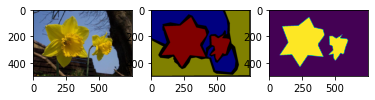

In [144]:
img, sgm, binarized_sgm= read_images_with_binarization(7,plot=True)

Saving binarized segmentations, to lower preprocess time

In [143]:
import PIL

for sgm_id in tqdm.tqdm(sgm_files_set):
    img, sgm, binarized_sgm= read_images_with_binarization(sgm_id)
    binarized_sgm_PIL=PIL.Image.fromarray(binarized_sgm.astype(np.bool))
    binarized_sgm_PIL.save(f"data/segmentations/image_{sgm_id:04}.png")
    

  0%|          | 0/848 [00:00<?, ?it/s]/var/folders/j0/y36t88xs5z1fb7hd9lzv0qt00000gn/T/ipykernel_44312/28760512.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  binarized_sgm_PIL=PIL.Image.fromarray(binarized_sgm.astype(np.bool))
100%|██████████| 848/848 [28:26<00:00,  2.01s/it]
